# Install Libraries & Dependencies

In [1]:
pip install scikit-image

In [2]:
!pip install scikit-image --upgrade


In [3]:
import os
import numpy as np
import cv2
import glob
import random
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from skimage.feature import graycomatrix, graycoprops
import tensorflow as tf
from tensorflow.keras import layers, models

# Data Preprocessing

In [4]:
import zipfile
from pathlib import Path

# full path avoids ambiguity
zip_path = Path('/content/BraTs18.zip')  # change to your real location

if not zip_path.exists():
    raise FileNotFoundError(f"{zip_path} does not exist. "
                            "Check the path or upload the file.")

with zipfile.ZipFile(zip_path, 'r') as z:
    z.extractall('/content')

In [6]:
images_dir = "/content/brats18/images"
masks_dir = "/content/brats18/masks"

image_files = sorted(glob.glob(os.path.join(images_dir, "image_*.png")))
print(f"Found {len(image_files)} image files: {image_files}")

mask_files = sorted(glob.glob(os.path.join(masks_dir, "mask_*.png")))
print(f"Found {len(mask_files)} mask files: {mask_files}")

Found 5042 image files: ['/content/brats18/images/image_1.png', '/content/brats18/images/image_10.png', '/content/brats18/images/image_100.png', '/content/brats18/images/image_1000.png', '/content/brats18/images/image_1001.png', '/content/brats18/images/image_1002.png', '/content/brats18/images/image_1003.png', '/content/brats18/images/image_1004.png', '/content/brats18/images/image_1005.png', '/content/brats18/images/image_1006.png', '/content/brats18/images/image_1007.png', '/content/brats18/images/image_1008.png', '/content/brats18/images/image_1009.png', '/content/brats18/images/image_101.png', '/content/brats18/images/image_1010.png', '/content/brats18/images/image_1011.png', '/content/brats18/images/image_1012.png', '/content/brats18/images/image_1013.png', '/content/brats18/images/image_1014.png', '/content/brats18/images/image_1015.png', '/content/brats18/images/image_1016.png', '/content/brats18/images/image_1017.png', '/content/brats18/images/image_1018.png', '/content/brats1

In [7]:
assert len(image_files) == len(mask_files), "Mismatch between images and masks!"

In [8]:
# Function to load an image as grayscale
def load_image(file_path):
    image = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
    return image

In [9]:
# Function to normalize an image by scaling pixel values to the range [0, 1]
def normalize_image(image):
    image = image.astype(np.float32)
    return image / 255.0

In [10]:
# Function to apply Contrast Limited Adaptive Histogram Equalization (CLAHE) to enhance contrast
def enhance_contrast(image):
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    return clahe.apply((image * 255).astype(np.uint8)) / 255.0

In [11]:
# Function to resize an image to the target size (default 112x112)
def resize_image(image, target_size=(112, 112)):
    return cv2.resize(image, target_size)

In [12]:
# Function to preprocess the image by normalizing, enhancing contrast, and resizing
def preprocess_image(file_path, target_size=(112, 112)):
    image = load_image(file_path)
    normalized_image = normalize_image(image)
    enhanced_image = enhance_contrast(normalized_image)
    resized_image = resize_image(enhanced_image, target_size)
    return resized_image

In [13]:
# Shuffle and split the data into training and validation sets (80%/20%)
combined = list(zip(image_files, mask_files))
random.shuffle(combined)
split_idx = int(len(combined) * 0.8)
train_pairs = combined[:split_idx]
val_pairs = combined[split_idx:]

In [14]:
# Apply preprocessing to training and validation images
train_images = [preprocess_image(img_path) for img_path, _ in train_pairs]
train_masks = [load_image(mask_path) for _, mask_path in train_pairs]
val_images = [preprocess_image(img_path) for img_path, _ in val_pairs]
val_masks = [load_image(mask_path) for _, mask_path in val_pairs]

In [15]:
print(f"Sample preprocessed image shape: {train_images[0].shape}")
print(f"Sample mask shape: {train_masks[0].shape}")

Sample preprocessed image shape: (112, 112)
Sample mask shape: (240, 240)


# Exploratory Data Analysis (EDA)

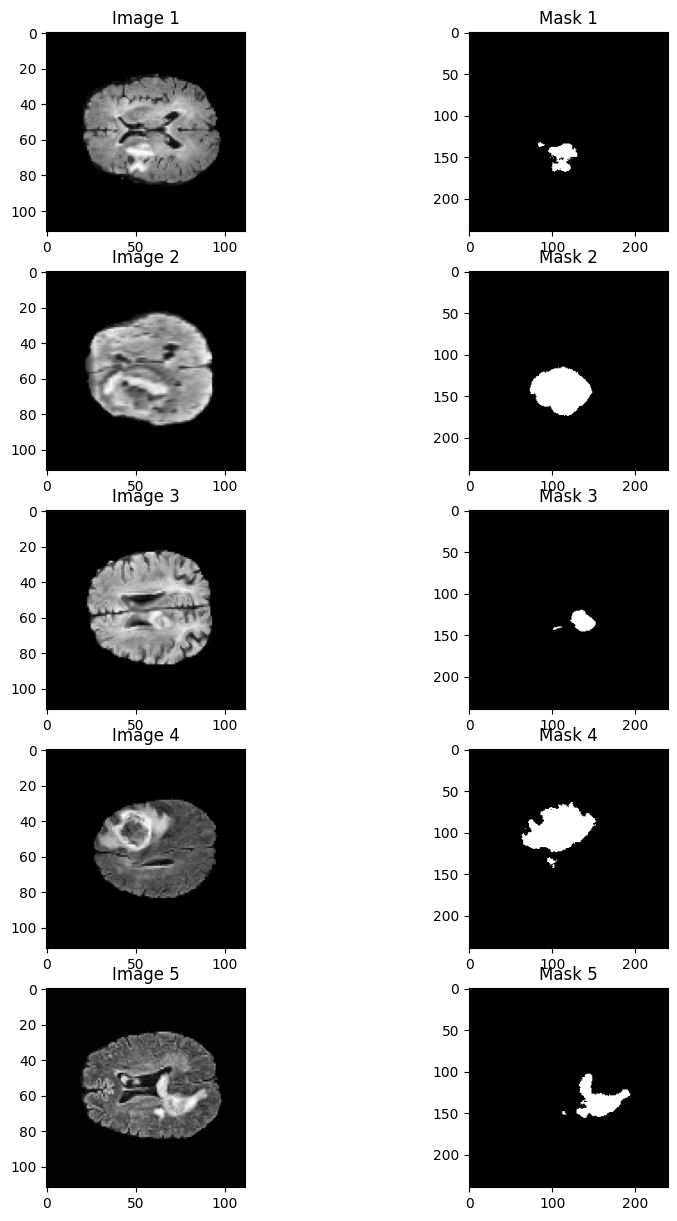

In [16]:
# Function to display sample images and their corresponding masks
def display_sample_images(images, masks, n_samples=5):
    fig, axes = plt.subplots(n_samples, 2, figsize=(10, 15))
    for i in range(n_samples):
        axes[i, 0].imshow(images[i], cmap='gray')
        axes[i, 0].set_title(f"Image {i+1}")
        axes[i, 1].imshow(masks[i], cmap='gray')
        axes[i, 1].set_title(f"Mask {i+1}")
    plt.show()

display_sample_images(train_images, train_masks)

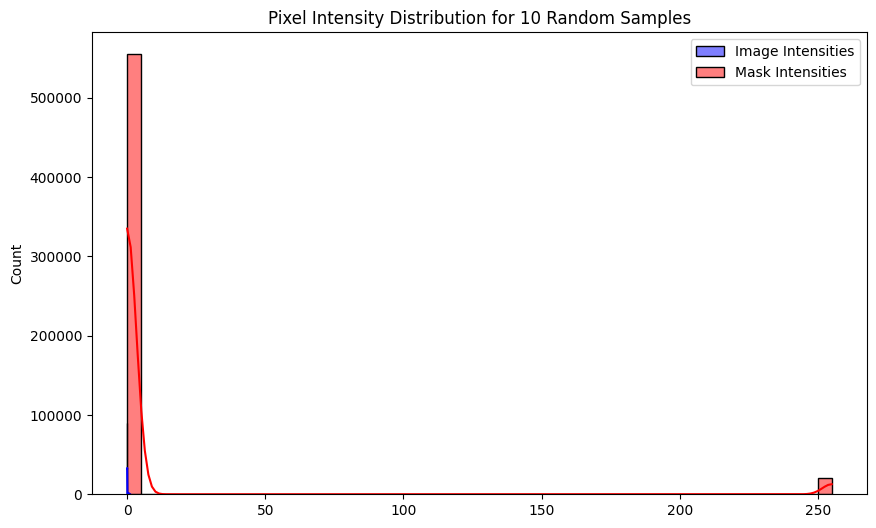

In [17]:
# Function to plot pixel intensity distribution for a small sample of images and masks
import random
def plot_pixel_intensity_histogram(images, masks, sample_size=10):
    sample_indices = random.sample(range(len(images)), sample_size)
    sample_images = [images[i] for i in sample_indices]
    sample_masks = [masks[i] for i in sample_indices]
    image_intensity = np.concatenate([img.flatten() for img in sample_images])
    mask_intensity = np.concatenate([mask.flatten() for mask in sample_masks])
    plt.figure(figsize=(10, 6))
    sns.histplot(image_intensity, bins=50, color='blue', label='Image Intensities', kde=True)
    sns.histplot(mask_intensity, bins=50, color='red', label='Mask Intensities', kde=True)
    plt.legend()
    plt.title(f'Pixel Intensity Distribution for {sample_size} Random Samples')
    plt.show()

plot_pixel_intensity_histogram(train_images, train_masks, sample_size=10)


# Feature Engineering

In [18]:
# Function to extract texture features using Grey Level Co-occurrence Matrix (GLCM)
def extract_texture_features(image):
    image = (image * 255).astype(np.uint8)
    glcm = graycomatrix(image, [1], [0], symmetric=True, normed=True)
    contrast = graycoprops(glcm, 'contrast')
    correlation = graycoprops(glcm, 'correlation')
    energy = graycoprops(glcm, 'energy')
    homogeneity = graycoprops(glcm, 'homogeneity')
    return contrast[0, 0], correlation[0, 0], energy[0, 0], homogeneity[0, 0]

features = extract_texture_features(train_images[0])
print("Texture Features (Contrast, Correlation, Energy, Homogeneity):", features)

Texture Features (Contrast, Correlation, Energy, Homogeneity): (276.02461389961394, 0.9654518633139001, 0.6762585416701614, 0.7019177335249134)


# U NET

In [87]:
def clean_and_resize_mask(mask, target=(112,112)):
    m = resize_image(mask, target).astype(np.int32)

    # Everything non‑zero becomes "tumour other" (ID 3) first
    m[m != 0] = 3

    # Optional: if your dataset has finer labels (1,2,4,255 etc.)
    # map them here; otherwise they stay 3.
    m[m == 1] = 1            # necrosis          → 1
    m[m == 2] = 2            # edema             → 2
    m[np.isin(m, [4,250,255])] = 3   # enhance/white → 3

    # Ensure no stray values
    m[~np.isin(m, [0,1,2,3])] = 3
    return m

In [88]:
train_masks_rs = [clean_and_resize_mask(m) for m in train_masks]
val_masks_rs   = [clean_and_resize_mask(m) for m in val_masks]

print("unique labels after cleanup:", np.unique(train_masks_rs[0]))

unique labels after cleanup: [0 3]


In [89]:
X_train = np.array(train_images)[..., np.newaxis]         # (N,112,112,1)
Y_train = np.array(train_masks_rs, dtype=np.int32)        # (N,112,112)
X_val   = np.array(val_images )[..., np.newaxis]
Y_val   = np.array(val_masks_rs , dtype=np.int32)

In [90]:
NUM_CLASSES = 4

In [91]:
print("check shapes:", Y_train.shape, Y_val.shape)

check shapes: (4033, 112, 112) (1009, 112, 112)


In [92]:
def conv_block(x, f):
    x = layers.Conv2D(f, 3, padding='same', activation='relu')(x)
    x = layers.Conv2D(f, 3, padding='same', activation='relu')(x)
    return x


In [93]:
def build_unet(input_shape=(112,112,1), classes=NUM_CLASSES):
    inputs = layers.Input(input_shape)
    # encoder
    c1 = conv_block(inputs, 32);  p1 = layers.MaxPool2D()(c1)
    c2 = conv_block(p1,    64);   p2 = layers.MaxPool2D()(c2)
    c3 = conv_block(p2,   128);   p3 = layers.MaxPool2D()(c3)
    c4 = conv_block(p3,   256);   p4 = layers.MaxPool2D()(c4)
    # bottleneck
    bn = conv_block(p4,   512)
    # decoder
    u4 = layers.Conv2DTranspose(256,2,2,'same')(bn); u4 = layers.concatenate([u4,c4]); u4 = conv_block(u4,256)
    u3 = layers.Conv2DTranspose(128,2,2,'same')(u4); u3 = layers.concatenate([u3,c3]); u3 = conv_block(u3,128)
    u2 = layers.Conv2DTranspose( 64,2,2,'same')(u3); u2 = layers.concatenate([u2,c2]); u2 = conv_block(u2, 64)
    u1 = layers.Conv2DTranspose( 32,2,2,'same')(u2); u1 = layers.concatenate([u1,c1]); u1 = conv_block(u1, 32)
    outputs = layers.Conv2D(classes, 1, activation='softmax')(u1)
    return models.Model(inputs, outputs, name='U_Net')

In [94]:
unet = build_unet(classes=NUM_CLASSES)
unet.compile(optimizer='adam',
             loss=tf.keras.losses.SparseCategoricalCrossentropy(),
             metrics=['accuracy'])

In [95]:
BATCH = 8

train_ds = (
    tf.data.Dataset
      .from_tensor_slices((train_masks_rs, Y_train))
      .shuffle(len(train_masks_rs))
      .batch(BATCH)
      .repeat()                 # repeat forever → fit() controls length
)

In [96]:
val_ds = tf.data.Dataset.from_tensor_slices((val_masks_rs, Y_val)).batch(BATCH)

In [97]:
history = unet.fit(
    train_ds,
    steps_per_epoch = 10,                   # 👈 exactly 50 mini‑batches/epoch
    validation_data = val_ds,
    validation_steps = len(X_val) // BATCH, # enough batches to cover val set
    epochs = 15
)

Epoch 1/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 156s 16s/step - accuracy: 0.6747 - loss: 1.3479 - val_accuracy: 0.6789 - val_loss: 1.1814
Epoch 2/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 205s 22s/step - accuracy: 0.8620 - loss: 1.1656 - val_accuracy: 0.9767 - val_loss: 1.0178
Epoch 3/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 143s 15s/step - accuracy: 0.9800 - loss: 0.8923 - val_accuracy: 0.9829 - val_loss: 0.2531
Epoch 4/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 143s 16s/step - accuracy: 0.9751 - loss: 0.1552 - val_accuracy: 0.9921 - val_loss: 0.0237
Epoch 5/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 202s 22s/step - accuracy: 0.9951 - loss: 0.0162 - val_accuracy: 0.9943 - val_loss: 0.0156
Epoch 6/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 145s 16s/step - accuracy: 0.9943 - loss: 0.0148 - val_accuracy: 0.9958 - val_loss: 0.0107
Epoch 7/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 208s 23s/step - accuracy: 0.9963 - loss: 0.0095 - val_accuracy: 0.9961 - val_loss: 0.0101
Epoch 8/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 141s 15s/step - accuracy: 0.9964 - loss: 0.0097 - val_accuracy: 0.

In [98]:
sample_img = X_val[0:1]

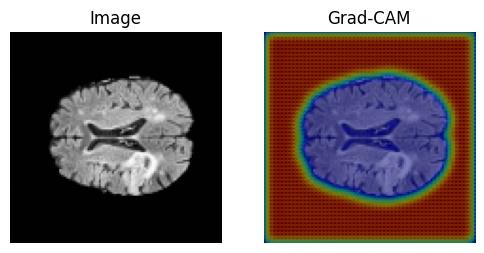

In [101]:
last_conv = [l for l in unet.layers if isinstance(l, tf.keras.layers.Conv2D)][-3]

with tf.GradientTape() as tape:
    conv_out, preds = models.Model(unet.inputs, [last_conv.output, unet.output])(sample_img)
    target_class = tf.argmax(tf.reduce_mean(preds, axis=[1, 2, 3]))
    loss = preds[..., target_class]

grads   = tape.gradient(loss, conv_out)
pooled  = tf.reduce_mean(grads, axis=(0, 1, 2))
heatmap = tf.reduce_mean(tf.multiply(pooled, conv_out), axis=-1)[0]
heatmap = tf.maximum(heatmap, 0) / tf.reduce_max(heatmap)

plt.figure(figsize=(6, 3))
plt.subplot(1, 2, 1); plt.imshow(sample_img[0, :, :, 0], cmap='gray'); plt.axis('off'); plt.title('Image')
plt.subplot(1, 2, 2); plt.imshow(sample_img[0, :, :, 0], cmap='gray')
plt.imshow(heatmap, cmap='jet', alpha=0.5); plt.axis('off'); plt.title('Grad‑CAM')
plt.show()

In [129]:
import numpy as np, matplotlib.pyplot as plt, tensorflow as tf, shap
from shap.explainers import Gradient

In [ ]:
import numpy as np, matplotlib.pyplot as plt, tensorflow as tf, shap
from shap.explainers import Gradient

# 1️⃣  pooled‑logit wrapper → vector of length 4
pooled_logits = tf.keras.layers.GlobalAveragePooling2D()(unet.output)
vec_model     = tf.keras.Model(unet.inputs, pooled_logits)

# 2️⃣  Gradient explainer with a small background set
bg_idx    = np.random.choice(len(X_train), 10, replace=False)
explainer = Gradient(vec_model, data=X_train[bg_idx])

# 3️⃣  explain ONE validation image (index 0)
sample_img = X_val[0:1].astype(np.float32)         # shape (1,112,112,1)
exp        = explainer(sample_img)                 # exp is shap.Explanation

# 4️⃣  pick class to visualise (0‑bg,1‑necrosis,2‑edema,3‑enhancing)
class_idx  = 1
# exp.values shape: (samples, H, W, C, outputs)
attr_map   = exp.values[0, :, :, 0, class_idx]     # (112,112)

# 5️⃣  robust scaling + pretty overlay
vmax = np.percentile(np.abs(attr_map), 99)
attr_viz = np.clip(attr_map, -vmax, vmax)

fig, ax = plt.subplots(1, 2, figsize=(6, 3))
ax[0].imshow(sample_img[0, :, :, 0], cmap="gray")
ax[0].axis("off"); ax[0].set_title("Image")

ax[1].imshow(sample_img[0, :, :, 0], cmap="gray")
im = ax[1].imshow(attr_viz, cmap="seismic", alpha=0.6,
                  vmin=-vmax, vmax=vmax)
ax[1].axis("off"); ax[1].set_title(f"SHAP  class {class_idx}")
fig.colorbar(im, ax=ax.ravel().tolist(), fraction=0.046, pad=0.04)
plt.tight_layout(); plt.show()

<ipython-input-143-e62082ceadf0>:10: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(); plt.show()


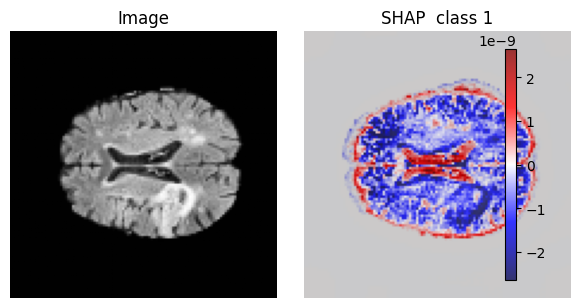

In [143]:
fig, ax = plt.subplots(1, 2, figsize=(6, 3))
ax[0].imshow(sample_img[0, :, :, 0], cmap="gray")
ax[0].axis("off"); ax[0].set_title("Image")

ax[1].imshow(sample_img[0, :, :, 0], cmap="gray")
im = ax[1].imshow(attr_viz, cmap="seismic", alpha=0.8,
                  vmin=-vmax, vmax=vmax)
ax[1].axis("off"); ax[1].set_title(f"SHAP  class {class_idx}")
fig.colorbar(im, ax=ax.ravel().tolist(), fraction=0.046, pad=0.04)
plt.tight_layout(); plt.show()

In [144]:
!pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 5.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=8ccf17fb119f22b11ce5ed6175f6bd93db2c5265c9db2fec34496ed35ace6a36
  Stored in directory: /root/.cache/pip/wheels/85/fa/a3/9c2d44c9f3cd77cf4e533b58900b2bf4487f2a17e8ec212a3d
Successfully built lime


In [ ]:
from lime import lime_image
from skimage.segmentation import mark_boundaries
from skimage.color import gray2rgb  # Import gray2rgb

def predict_fn(imgs):  # LIME callback
    # Reshape imgs to have a single channel (grayscale)
    imgs = imgs.reshape(-1, 112, 112, 1)
    # Get predictions
    preds = unet.predict(imgs)
    # Return the average prediction across all classes for each image segment
    # This creates a 1D array suitable for Ridge regression.
    return preds.mean(axis=(1, 2, 3)) # Average across all dimensions except the batch dimension

lime_exp = lime_image.LimeImageExplainer()
# Convert the grayscale image to RGB before passing it to explain_instance
# Remove the extra dimension using squeeze()
rgb_sample_img = gray2rgb(sample_img[0].squeeze().astype(float))
explanation = lime_exp.explain_instance(
    rgb_sample_img,
    classifier_fn=predict_fn,
    top_labels=3,
    hide_color=0,
    num_samples=1000
)

temp, mask = explanation.get_image_and_mask(
    label=explanation.top_labels[0],
    positive_only=False,
    hide_rest=False,
    num_features=10,
    min_weight=0.05
)

plt.imshow(mark_boundaries(temp.squeeze(), mask))
plt.axis('off')
plt.title('LIME super-pixels')
plt.show()

In [168]:
!pip install -q tf-keras-vis

In [169]:
from tf_keras_vis.saliency import Saliency
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear

<ipython-input-179-4ba5a1ddab47>:61: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(); plt.show()


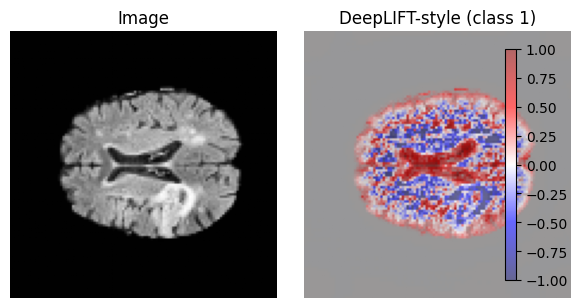

In [179]:
# =============================================================
# DeepLIFT-style via Integrated Gradients (100 steps)
# =============================================================
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

def deeplift_style(model, x, class_idx, steps=100):
    """
    Approximates DeepLIFT by computing Integrated Gradients with many steps.
    model     : tf.keras.Model → segmentation map (1,H,W,C)
    x         : input image tensor (1,H,W,1), float32 [0,1]
    class_idx : which channel to explain (0..C-1)
    steps     : number of interpolation points
    """
    x = tf.cast(x, tf.float32)
    baseline = tf.zeros_like(x)

    # 1️⃣  build interpolated inputs
    alphas = tf.linspace(0.0, 1.0, steps + 1)[:, None, None, None, None]
    interp = baseline + alphas * (x - baseline)
    interp = tf.reshape(interp, [-1, *x.shape[1:]])  # (steps+1, H, W, 1)

    # 2️⃣  record gradients
    with tf.GradientTape() as tape:
        tape.watch(interp)
        preds = model(interp)                      # (steps+1,H,W,C)
        scores = preds[..., class_idx]             # (steps+1,H,W)
    grads = tape.gradient(scores, interp)          # (steps+1,H,W,1)

    # 3️⃣  trapezoidal approximation of the path integral
    grads = tf.reshape(grads, [steps+1, *x.shape[1:]])
    avg_grads = (grads[:-1] + grads[1:]) / 2.0
    avg_grads = tf.reduce_mean(avg_grads, axis=0)  # (H,W,1)

    # 4️⃣  compute attribution
    attr = (x[0,...,0] - baseline[0,...,0]) * tf.squeeze(avg_grads)
    return attr.numpy()

# ---------------------------
# Usage example
# ---------------------------
# pick a slice + class
sample_idx = 0
class_idx  = 1    # 0=bg,1=necrosis,2=edema,3=enhancing
x = X_val[sample_idx:sample_idx+1].astype(np.float32)

# compute "DeepLIFT-style" attributions
attr = deeplift_style(unet, x, class_idx, steps=100)

# robust scaling & plot
vmax    = np.percentile(np.abs(attr), 99)
attr_viz= np.clip(attr, -vmax, vmax) / (vmax + 1e-8)

fig, ax = plt.subplots(1, 2, figsize=(6, 3))
ax[0].imshow(x[0, ..., 0], cmap='gray'); ax[0].axis('off'); ax[0].set_title('Image')
ax[1].imshow(x[0, ..., 0], cmap='gray')
im = ax[1].imshow(attr_viz, cmap='seismic', alpha=0.6, vmin=-1, vmax=1)
ax[1].axis('off'); ax[1].set_title(f'DeepLIFT-style (class {class_idx})')
fig.colorbar(im, ax=ax.ravel().tolist(), fraction=0.046, pad=0.04)
plt.tight_layout(); plt.show()
